# Water Usage in Baltimore

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
#from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

In [3]:
url1 = ('https://raw.githubusercontent.com/jbrownlee/Datasets/master/yearly-water-usage.csv')

df = pd.read_csv(url1)

df

,Year,Water
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413
...,...,...
74,1959,594
75,1960,587
76,1961,587
77,1962,625


In [4]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index(['Year'])


df.head()

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


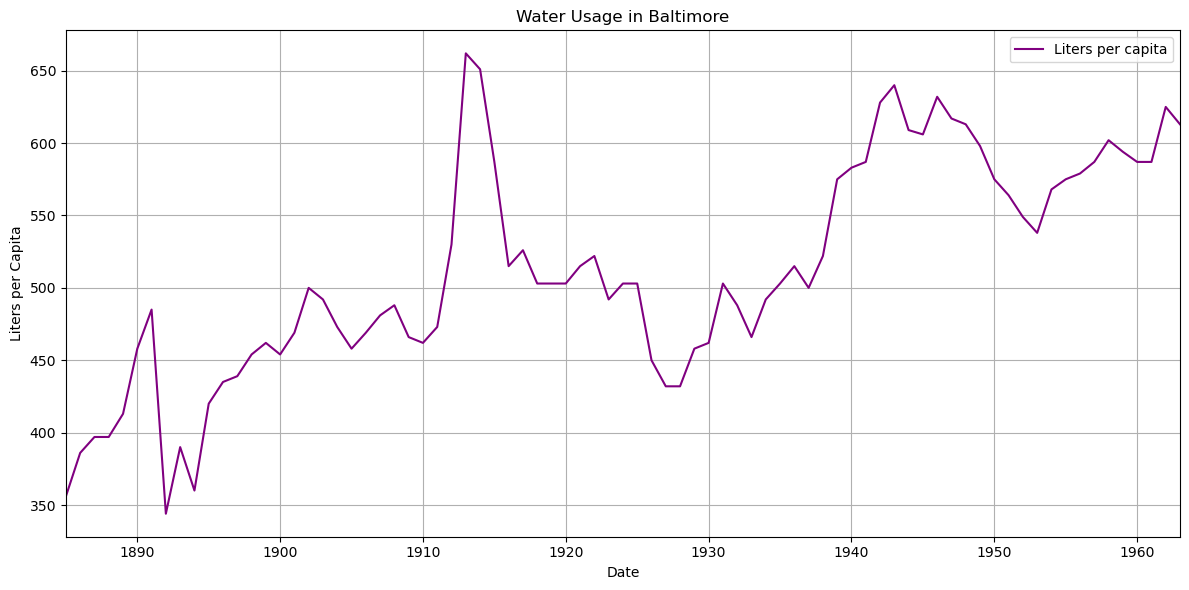

In [5]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df.index, df['Water'], label='Liters per capita', color='purple')     

plt.title('Water Usage in Baltimore')                      
plt.xlabel('Date')                                        
plt.ylabel('Liters per Capita')  
plt.xlim(pd.to_datetime('1885-01-01'), pd.to_datetime('1963-01-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [6]:
# Convert to datetime for the comparison
train = df[df.index < pd.to_datetime('1955-01-01')]     # All data before March
test = df[df.index >= pd.to_datetime('1955-01-01')]     # All data in March and beyond

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (70, 1)
Test shape: (9, 1)




(            Water
 Year             
 1950-01-01    575
 1951-01-01    564
 1952-01-01    549
 1953-01-01    538
 1954-01-01    568,
 None,
             Water
 Year             
 1955-01-01    575
 1956-01-01    579
 1957-01-01    587
 1958-01-01    602
 1959-01-01    594)

In [7]:
water_series = train['Water']

In [8]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(water_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.1965, p-value = 0.2075
d = 1 | ADF Statistic = -6.2237, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [9]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(water_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 1
Seasonal differencing term (D) for 52: 0


In [10]:
from pmdarima.arima import nsdiffs

D = nsdiffs(water_series, m=12, test='ch') # Canova-Hansen Test (ch) is designed for monthly or quarterly data.
print("Seasonal differencing term (D):", D)

Seasonal differencing term (D): 0


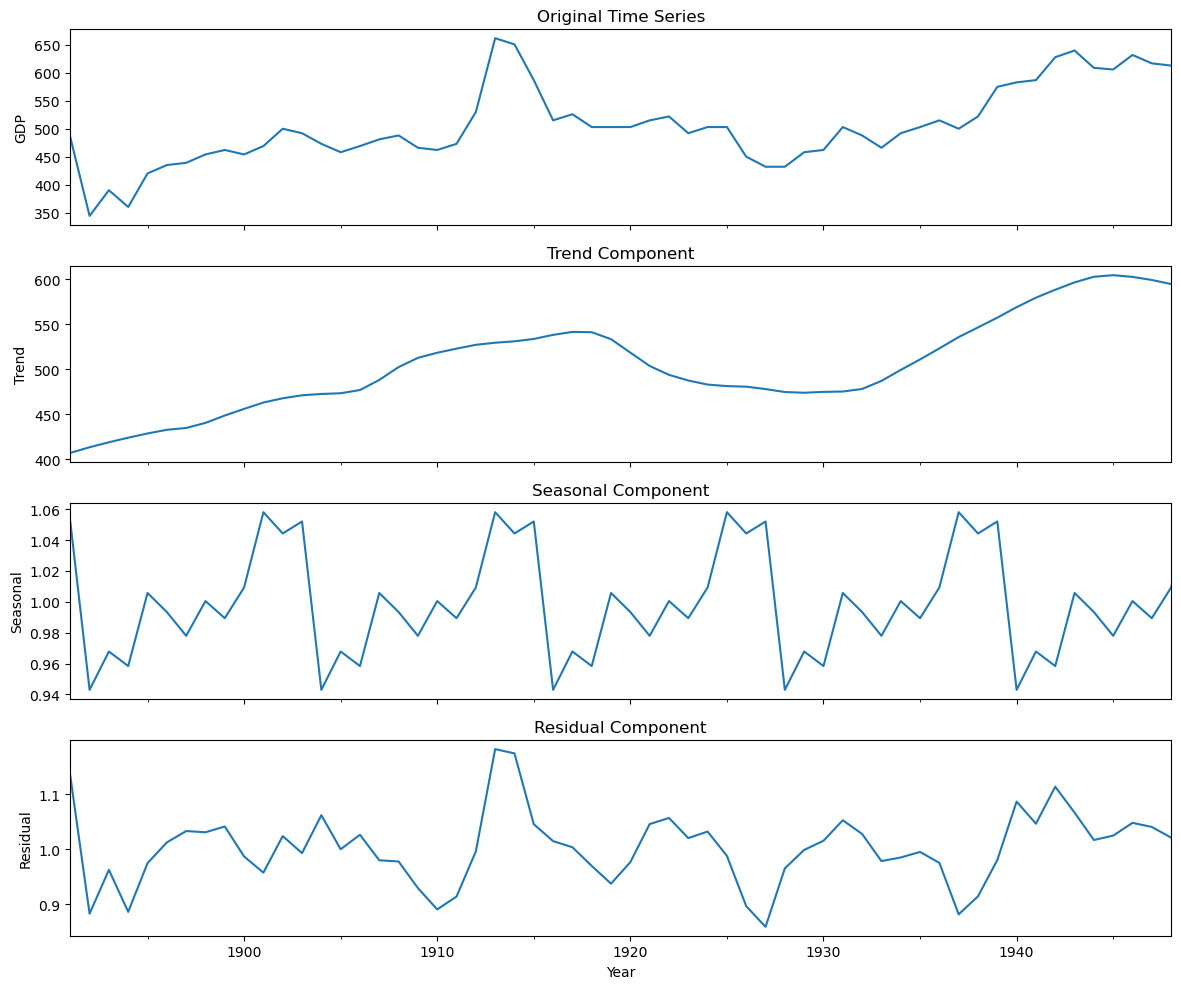

In [11]:
result = seasonal_decompose(water_series, model='multiplicative', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('GDP')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [12]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    water_series,               # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(0, 1, 0)(0, 0, 0, 12)


In [13]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2            # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(water_series,                  # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,187,"(2, 1, 3)","(2, 0, 3)",264.807849,280.337261,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,251,"(3, 1, 3)","(2, 0, 3)",265.402852,284.902852,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,255,"(3, 1, 3)","(3, 0, 3)",265.495054,289.761721,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,191,"(2, 1, 3)","(3, 0, 3)",266.579152,286.079152,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,59,"(0, 1, 3)","(2, 0, 3)",269.753748,279.227433,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


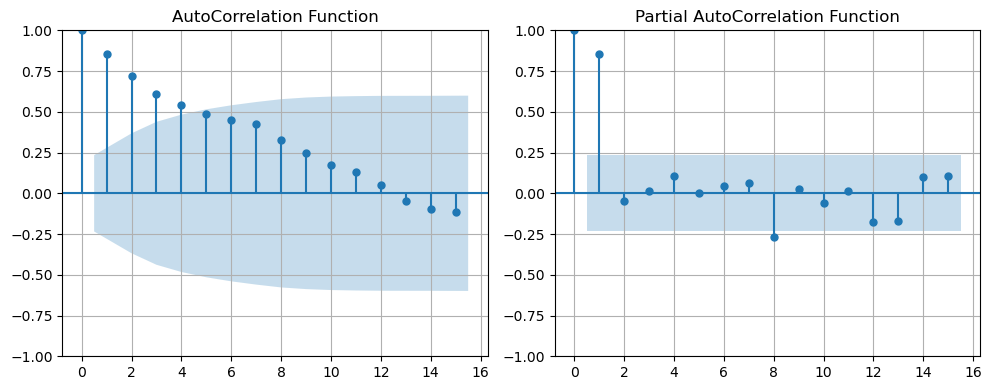

In [14]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(water_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(water_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_213 = SARIMAX(water_series,                          # Time series data
                    order=(2, 1, 3),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 3, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_213 = model_213.fit()

# Display summary of the model
print(model_fit_213.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Water   No. Observations:                   70
Model:             SARIMAX(2, 1, 3)x(2, 0, 3, 12)   Log Likelihood                -121.404
Date:                            Wed, 16 Apr 2025   AIC                            264.808
Time:                                    15:55:05   BIC                            279.848
Sample:                                01-01-1885   HQIC                           269.518
                                     - 01-01-1954                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3262      0.115     -2.836      0.005      -0.552      -0.101
ar.L2         -0.9098      0.080   

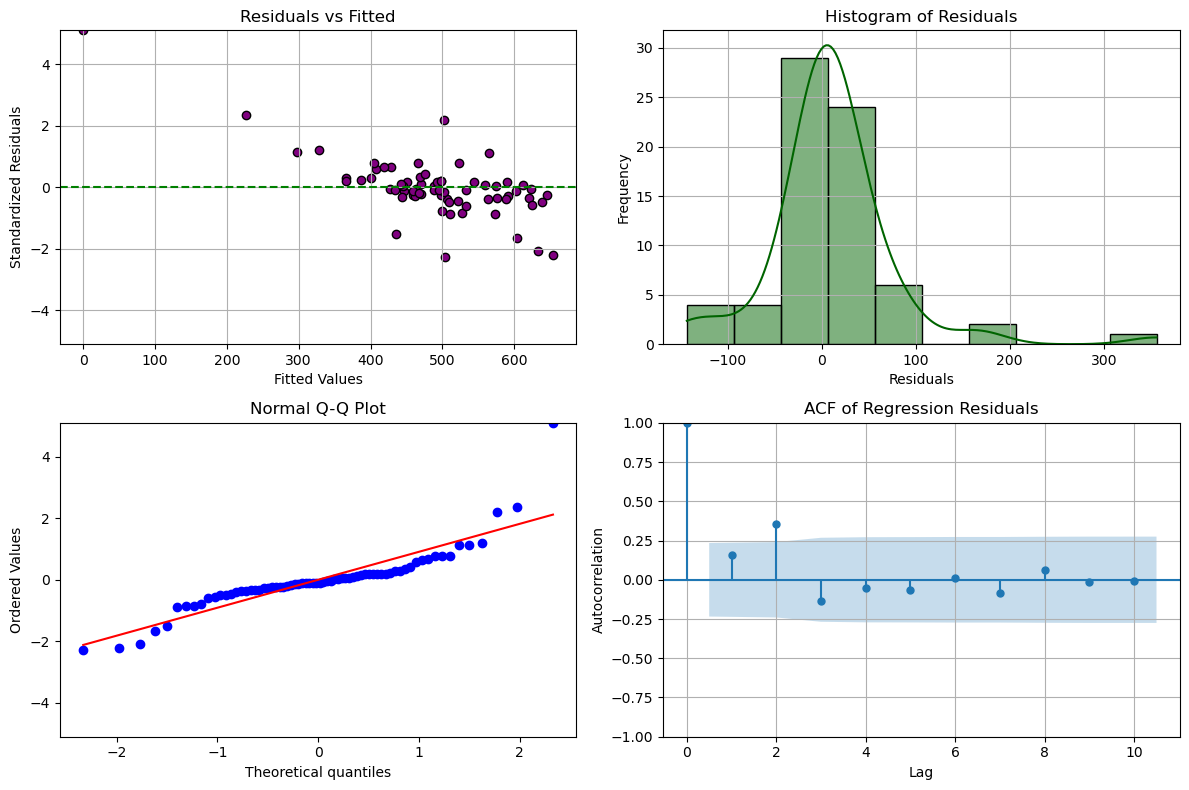

In [16]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_213.resid  

# Extract fitted values from the fitted model
fitted = model_fit_213.fittedvalues

# Standardize Residuals
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Standardized Residuals vs Fitted
axes[0, 0].scatter(fitted, standardized_residuals, color='purple', edgecolor='k')
axes[0, 0].axhline(y=0, color='green', linestyle='--')          
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
max_resid = max(abs(standardized_residuals))
axes[0, 0].set_ylim(-max_resid, max_resid)
axes[0, 0].grid(True)

# 2. Histogram of Residuals
sns.histplot(residuals, bins=10, edgecolor='black', color='darkgreen', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
axes[1, 0].set_ylim(-max_resid, max_resid)
axes[1, 0].grid(False)

# 4. Correlogram (ACF)
plot_acf(residuals, lags=10, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Regression Residuals')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True)

# Show layout
plt.tight_layout()
plt.show()

In [17]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_213.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,1.871703,0.171280
2,11.295391,0.003526
3,12.644495,0.005472
4,12.870929,0.011924
5,13.182214,0.021730
6,13.188500,0.040138
7,13.757895,0.055659
8,14.082053,0.079652
9,14.102149,0.118738
10,14.105979,0.168212


In [18]:
from statsmodels.stats.stattools import durbin_watson

# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.2695
Conclusion: Evidence of positive autocorrelation.


In [19]:
# Forecast the next steps time points
forecast_9 = model_fit_213.get_forecast(steps=9)

# Extract predicted mean and confidence intervals
forecast_mean_9 = forecast_9.predicted_mean
conf_int_9 = forecast_9.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_9.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Water']

test['Lower 95% CI'] = conf_int_9.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_9.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Water,Forecast,Error,Lower 95% CI,Upper 95% CI
Year,,,,,
1955-01-01,575,574.986799,-0.013201,546.955085,603.018513
1956-01-01,579,578.405003,-0.594997,520.629696,636.180311
1957-01-01,587,586.924623,-0.075377,510.509948,663.339299
1958-01-01,602,578.244512,-23.755488,485.211920,671.277103
1959-01-01,594,573.639669,-20.360331,466.801348,680.477991
1960-01-01,587,571.382694,-15.617306,453.454371,689.311017
1961-01-01,587,568.376506,-18.623494,439.793544,696.959468
1962-01-01,625,561.279411,-63.720589,422.132767,700.426055
1963-01-01,613,552.391351,-60.608649,404.068660,700.714042


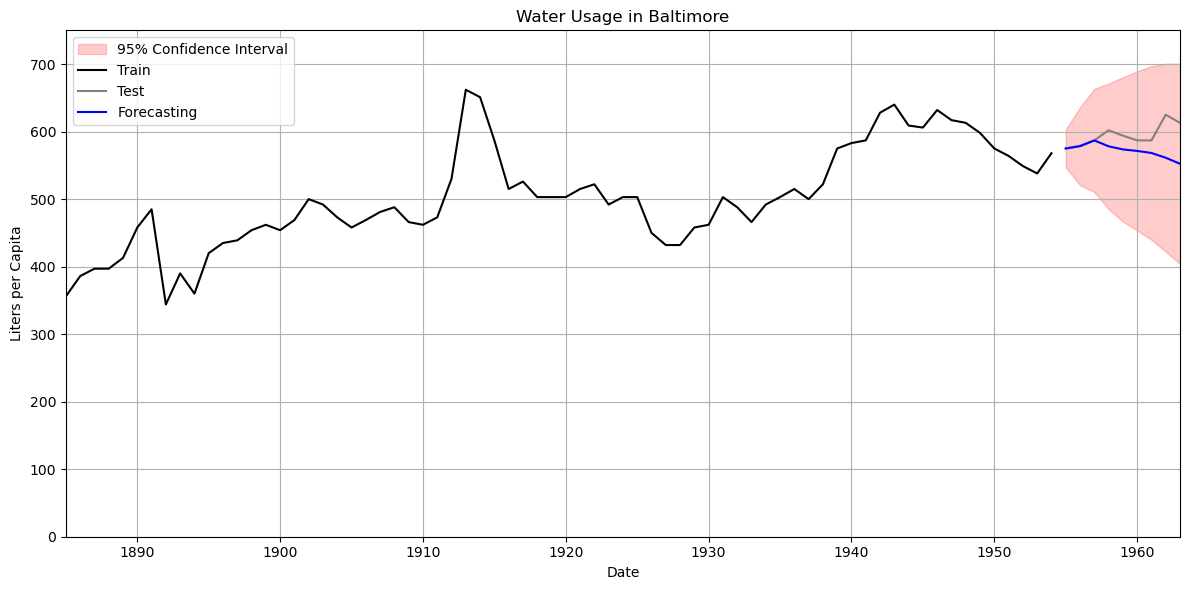

In [20]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_9.iloc[:, 0],     # Lower bound
                 conf_int_9.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Water'], label='Train', color='black')                      
plt.plot(test.index, test['Water'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast'], label='Forecasting', color='blue') 

plt.title('Water Usage in Baltimore')                      
plt.xlabel('Date')                                        
plt.ylabel('Liters per Capita')  
plt.xlim(pd.to_datetime('1885-01-01'), pd.to_datetime('1963-01-01'))
plt.ylim(0, 750)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [21]:
# Compute MAPE
actual = test['Water']
forecast = test['Forecast']
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print(f'MAPE: {mape:.2f}%')

MAPE: 3.71%
